<a href="https://colab.research.google.com/github/Claraa1110/MRI-Tumor-Classification/blob/main/MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# PART 1 (最終完美版): 幾何保留 + ResNet50 微調
# 策略：關閉幾何破壞，讓模型學習「位置特徵」
# ==========================================
!pip install roboflow opencv-python matplotlib scikit-learn tensorflow seaborn

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  # 👈 回歸最穩定的 ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision
from sklearn.utils import class_weight
from roboflow import Roboflow

# 0. 清理舊模型
if os.path.exists('my_mri_model.h5'):
    os.remove('my_mri_model.h5')

# 開啟混合精度加速 (加速訓練)
mixed_precision.set_global_policy('mixed_float16')

# 1. 下載資料
rf = Roboflow(api_key="Fejkqw1NB22U2OhV41Ph")
project = rf.workspace("mri-l4mg5").project("mri-brain-tumor-nxio6")
version = project.version(2)
dataset = version.download("folder")

dataset_path = dataset.location
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")

# 2. 影像前處理 (CLAHE 增強腫瘤紋理)
def report_preprocessing(img):
    img = img.astype('uint8')
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # clipLimit 設為 2.0，增強對比但不至於產生太多雜訊
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    img_enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return img_enhanced.astype('float32')

# 3. 資料生成 (⚠️ 關鍵修正：幾乎不旋轉)
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    preprocessing_function=report_preprocessing,
    # 🔥 關鍵：只允許左右翻轉，嚴禁旋轉和大幅位移
    # 這樣才能保留 Meningioma (腦外) 和 Glioma (腦內) 的位置特徵
    horizontal_flip=True,
    rotation_range=0,      # 關閉旋轉
    width_shift_range=0.01, # 極小位移
    height_shift_range=0.01,# 極小位移
    rescale=1./255
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=report_preprocessing,
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

# 4. 權重計算 (使用自動平衡，不手動暴擊)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"⚖️ 自動平衡權重: {class_weights_dict}")

# 5. 建立模型 (ResNet50 部分微調)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 先凍結所有層
base_model.trainable = False

# 🔥 只解鎖最後 50 層
# 這樣既保留了基礎視覺能力，又讓高層能適應 MRI 紋理
for layer in base_model.layers[-50:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# 注意：混合精度下 softmax 需用 float32
predictions = Dense(train_generator.num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 6. 編譯設定 (使用適中學習率)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 7. 訓練設定
checkpoint = ModelCheckpoint('my_mri_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

print("🚀 開始幾何保留訓練 (ResNet50)...")

history = model.fit(
    train_generator,
    epochs=35,  # 35 次通常就夠了
    validation_data=valid_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

print("\n✅ 訓練完成！最佳模型已存檔為 'my_mri_model.h5'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MRI-Brain-Tumor-2 in folder:: 100%|██████████| 6669/6669 [00:01<00:00, 5395.14it/s]


Found 5826 images belonging to 4 classes.
Found 547 images belonging to 4 classes.
⚖️ 自動平衡權重: {0: np.float64(0.8592920353982301), 1: np.float64(0.8517543859649123), 2: np.float64(2.074786324786325), 3: np.float64(0.8472949389179756)}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
🚀 開始幾何保留訓練 (ResNet50)...


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.5264 - loss: 1.2988
Epoch 1: val_accuracy improved from -inf to 0.50274, saving model to my_mri_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 150s 623ms/step - accuracy: 0.5268 - loss: 1.2975 - val_accuracy: 0.5027 - val_loss: 1.0922 - learning_rate: 1.0000e-04
Epoch 2/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7104 - loss: 0.7629
Epoch 2: val_accuracy improved from 0.50274 to 0.64168, saving model to my_mri_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 88s 478ms/step - accuracy: 0.7104 - loss: 0.7629 - val_accuracy: 0.6417 - val_loss: 1.1896 - learning_rate: 1.0000e-04
Epoch 3/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.7404 - loss: 0.6799
Epoch 3: val_accuracy improved from 0.64168 to 0.70567, saving model to my_mri_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 86s 472ms/step - accuracy: 0.7404 - loss: 0.6799 - val_accuracy: 0.7057 - val_loss: 0.8276 - learning_rate: 1.0000e-04
Epoch 4/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.7453 - loss: 0.6466
Epoch 4: val_accuracy did not improve from 0.70567
183/183 ━━━━━━━━━━━━━━━━━━━━ 85s 465ms/step - accuracy: 0.7454 - loss: 0.6465 - val_accuracy: 0.6197 - val_loss: 1.7650 - learning_rate: 1.0000e-04
Epoch 5/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7729 - loss: 0.5874
Epoch 5: val_accuracy did not improve from 0.70567
183/183 ━━━━━━━━━━━━━━━━━━━━ 87s 473ms/step - accuracy: 0.7729 - loss: 0.5874 - val_accuracy: 0.6088 - val_loss: 1.3501 - learning_rate: 1.0000e-04
Epoch 6/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8037 - loss: 0.4900
Epoch 6: val_accuracy did not improve from 0.70567
183/183 ━━━━━━━━━━━━━━━━━━━━ 85s 463ms/step - accuracy: 0.8037 - loss: 0.4901 - val_accuracy: 0.6600 - val_loss: 1.8065 - learning_rate: 1.

183/183 ━━━━━━━━━━━━━━━━━━━━ 85s 463ms/step - accuracy: 0.8467 - loss: 0.3867 - val_accuracy: 0.8263 - val_loss: 0.5301 - learning_rate: 2.0000e-05
Epoch 8/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8743 - loss: 0.3134
Epoch 8: val_accuracy did not improve from 0.82633
183/183 ━━━━━━━━━━━━━━━━━━━━ 85s 466ms/step - accuracy: 0.8743 - loss: 0.3135 - val_accuracy: 0.8172 - val_loss: 0.5794 - learning_rate: 2.0000e-05
Epoch 9/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8885 - loss: 0.2971
Epoch 9: val_accuracy improved from 0.82633 to 0.83364, saving model to my_mri_model.h5


183/183 ━━━━━━━━━━━━━━━━━━━━ 87s 475ms/step - accuracy: 0.8885 - loss: 0.2970 - val_accuracy: 0.8336 - val_loss: 0.5179 - learning_rate: 2.0000e-05
Epoch 10/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9014 - loss: 0.2428
Epoch 10: val_accuracy did not improve from 0.83364
183/183 ━━━━━━━━━━━━━━━━━━━━ 85s 464ms/step - accuracy: 0.9013 - loss: 0.2429 - val_accuracy: 0.8062 - val_loss: 0.6644 - learning_rate: 2.0000e-05
Epoch 11/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8964 - loss: 0.2488
Epoch 11: val_accuracy did not improve from 0.83364
183/183 ━━━━━━━━━━━━━━━━━━━━ 84s 460ms/step - accuracy: 0.8964 - loss: 0.2488 - val_accuracy: 0.7477 - val_loss: 0.8546 - learning_rate: 2.0000e-05
Epoch 12/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8930 - loss: 0.2653
Epoch 12: val_accuracy did not improve from 0.83364
183/183 ━━━━━━━━━━━━━━━━━━━━ 85s 466ms/step - accuracy: 0.8930 - loss: 0.2652 - val_accuracy: 0.7623 - val_loss: 0.9161 - learning_ra

183/183 ━━━━━━━━━━━━━━━━━━━━ 87s 478ms/step - accuracy: 0.9214 - loss: 0.1886 - val_accuracy: 0.8720 - val_loss: 0.4582 - learning_rate: 4.0000e-06
Epoch 14/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9206 - loss: 0.1897
Epoch 14: val_accuracy did not improve from 0.87203
183/183 ━━━━━━━━━━━━━━━━━━━━ 86s 469ms/step - accuracy: 0.9207 - loss: 0.1897 - val_accuracy: 0.8611 - val_loss: 0.5095 - learning_rate: 4.0000e-06
Epoch 15/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9350 - loss: 0.1608
Epoch 15: val_accuracy did not improve from 0.87203
183/183 ━━━━━━━━━━━━━━━━━━━━ 85s 462ms/step - accuracy: 0.9350 - loss: 0.1608 - val_accuracy: 0.8556 - val_loss: 0.4918 - learning_rate: 4.0000e-06
Epoch 16/35
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9384 - loss: 0.1486
Epoch 16: val_accuracy did not improve from 0.87203
183/183 ━━━━━━━━━━━━━━━━━━━━ 86s 469ms/step - accuracy: 0.9384 - loss: 0.1486 - val_accuracy: 0.8629 - val_loss: 0.5063 - learning_ra

🔄 正在讀取模型 'my_mri_model.h5' ...


✅ 模型載入成功！

【 步驟 1 】請上傳一批「同一種類別」的照片


Saving image.jpg to image (7).jpg
Saving image(1).jpg to image(1) (7).jpg
Saving image(2).jpg to image(2) (7).jpg
Saving image(3).jpg to image(3) (7).jpg
Saving image(5).jpg to image(5) (7).jpg
Saving image(6).jpg to image(6) (7).jpg
Saving image(7).jpg to image(7) (7).jpg
Saving image(8).jpg to image(8) (7).jpg
Saving image(10).jpg to image(10) (7).jpg
Saving image(11).jpg to image(11) (7).jpg
Saving image(13).jpg to image(13) (7).jpg
Saving image(15).jpg to image(15) (7).jpg
Saving image(18).jpg to image(18) (7).jpg
Saving image(19).jpg to image(19) (7).jpg
Saving image(20).jpg to image(20) (7).jpg
Saving image(21).jpg to image(21) (7).jpg
Saving image(22).jpg to image(22) (7).jpg
Saving image(23).jpg to image(23) (7).jpg
Saving image(27).jpg to image(27) (7).jpg
Saving image(28).jpg to image(28) (7).jpg
Saving image(30).jpg to image(30) (7).jpg
Saving image(31).jpg to image(31) (7).jpg
Saving image(34).jpg to image(34) (7).jpg
Saving image(35).jpg to image(35) (7).jpg
Saving image(3

Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.


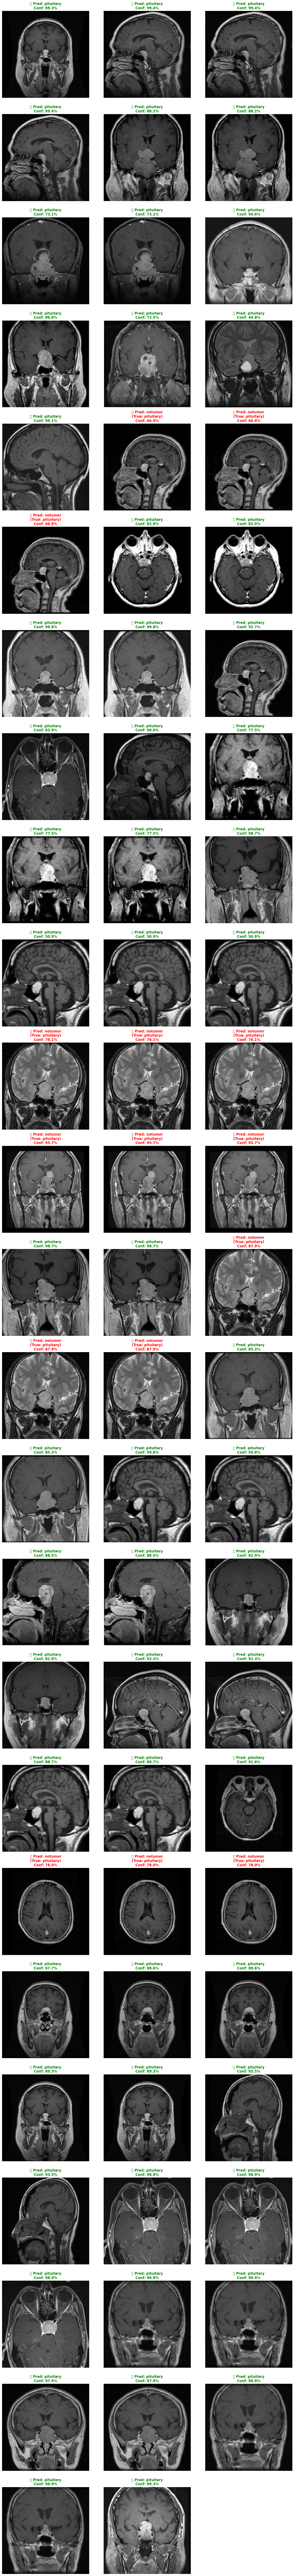


📊 測試報告 (Ground Truth: pituitary)
----------------------------------------
總張數    : 74
答對張數  : 59
答錯張數  : 15
----------------------------------------
🏆 本次準確率 : 79.73%


In [ ]:
# ==========================================
# PART 2 (互動測試版): 手動指定答案 + 計算準確率
# ==========================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import math

# 1. 定義影像前處理 (必須與訓練時一模一樣)
def report_preprocessing(img):
    img = img.astype('uint8')
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # 這裡維持 2.0，因為這是您剛才 EfficientNet 用的參數
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    img_enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return img_enhanced.astype('float32')

# 2. 載入模型
print("🔄 正在讀取模型 'my_mri_model.h5' ...")

if not os.path.exists('my_mri_model.h5'):
    print("❌ 錯誤：找不到模型檔案！請確認 Part 1 是否已跑完並存檔。")
else:
    # 載入模型 (需傳入自定義函數)
    model = load_model('my_mri_model.h5', custom_objects={'report_preprocessing': report_preprocessing})
    print("✅ 模型載入成功！")

    # 定義類別 (Roboflow 預設排序)
    class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

    print("\n" + "="*40)
    print("【 步驟 1 】請上傳一批「同一種類別」的照片")
    print("="*40)
    uploaded = files.upload()

    # 如果有上傳檔案
    if len(uploaded) > 0:
        num_files = len(uploaded)

        # 3. 詢問使用者正確答案
        print("\n" + "="*40)
        print("【 步驟 2 】請告訴我這批照片的正確答案是誰？")
        print(f" 0 : {class_labels[0]} (神經膠質瘤)")
        print(f" 1 : {class_labels[1]} (腦膜瘤)")
        print(f" 2 : {class_labels[2]} (無腫瘤)")
        print(f" 3 : {class_labels[3]} (垂體瘤)")
        print("="*40)

        while True:
            try:
                true_idx = int(input(f"請輸入正確類別的編號 (0-3): "))
                if 0 <= true_idx <= 3:
                    true_label_name = class_labels[true_idx]
                    break
                else:
                    print("⚠️ 請輸入 0 到 3 之間的數字！")
            except ValueError:
                print("⚠️ 請輸入數字！")

        print(f"\n🚀 收到！正在以「{true_label_name}」為標準進行批次評分...\n")

        # 4. 開始批次預測
        correct_count = 0
        cols = 3
        rows = math.ceil(num_files / cols)
        plt.figure(figsize=(15, 5 * rows))

        for i, fn in enumerate(uploaded.keys()):
            # A. 讀取
            ax = plt.subplot(rows, cols, i + 1)
            img = load_img(fn, target_size=(224, 224))

            # B. 預處理與預測
            x = img_to_array(img)
            x = report_preprocessing(x)
            x = np.expand_dims(x, axis=0)
            x = x / 255.0 # EfficientNet 訓練時若有 rescale，這裡也要有

            pred = model.predict(x, verbose=0)
            result_idx = np.argmax(pred[0])
            result_label = class_labels[result_idx]
            confidence = np.max(pred[0]) * 100

            # C. 判斷對錯
            is_correct = (result_idx == true_idx)
            if is_correct:
                correct_count += 1
                status_color = 'green'
                status_icon = '✅'
            else:
                status_color = 'red'
                status_icon = '❌'

            # D. 繪圖與標示
            plt.imshow(img)
            plt.axis('off')

            # 標題顯示：預測結果 (信心度)
            # 如果錯了，會括號顯示正確答案
            if is_correct:
                title_text = f"{status_icon} Pred: {result_label}\nConf: {confidence:.1f}%"
            else:
                title_text = f"{status_icon} Pred: {result_label}\n(True: {true_label_name})\nConf: {confidence:.1f}%"

            plt.title(title_text, color=status_color, fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # 5. 最終結算報告
        accuracy = (correct_count / num_files) * 100
        print("\n" + "="*40)
        print(f"📊 測試報告 (Ground Truth: {true_label_name})")
        print("-" * 40)
        print(f"總張數    : {num_files}")
        print(f"答對張數  : {correct_count}")
        print(f"答錯張數  : {num_files - correct_count}")
        print("-" * 40)
        print(f"🏆 本次準確率 : {accuracy:.2f}%")
        print("="*40)

    else:
        print("⚠️ 你沒有選擇任何檔案喔！")